In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


plt.style.use('ggplot')

import nltk

In [61]:
 from google.colab import drive

In [62]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [63]:
path = 'drive/My Drive/data'

In [64]:
try:
    df = pd.read_csv(path+'/13GEN.csv', encoding='utf-8')
except UnicodeDecodeError:
    df = pd.read_csv(path+'/13GEN.csv', encoding='ISO-8859-1')
print(df.shape)

(778, 6)


In [65]:
df.head(500)

,ID,Name,Stars,Title,Date,Description
0,1.0,Yeng,1,DO NOT GET,NaN,i'd say donât get this unless you want your ...
1,2.0,Amazon User,1,Crashes frequently,NaN,CPU crashed frequently on my Asus Strix ROG Z7...
2,3.0,Old Audio Nut,1,It came USED.,NaN,"The box was opened, the i5 sticker was missing..."
3,4.0,Andre in the north,1,Product never worked after installation,NaN,Product never worked after finally building sy...
4,5.0,Jypsy Martin,1,Product was defect,NaN,I returned it and ask for a refund the 6 of Oc...
...,...,...,...,...,...,...
495,496.0,FloncH,5,Por ahora perfecto,NaN,"For now, the processor is performing everythin..."
496,497.0,L&S,5,I7 13900KF,NaN,Juste incroyable rien a dire de plus
497,498.0,artyz,5,TrÃ¨s performant,NaN,"Very efficient processor in gaming,"
498,499.0,Andrii Sobol,5,"Good product, great quality.",NaN,"Good product, great quality."


DATA PREPROCESSING

In [66]:
# Downsampling data to only 500 rows
def to_lower(text):
    try:
        return str(text).lower()
    except AttributeError:
        return text

In [67]:
df['Description'] = df['Description'].apply(to_lower)

In [68]:
print(df[['Description']].head())

                                         Description
0  i'd say donât get this unless you want your ...
1  cpu crashed frequently on my asus strix rog z7...
2  the box was opened, the i5 sticker was missing...
3  product never worked after finally building sy...
4  i returned it and ask for a refund the 6 of oc...


In [69]:
df = df.sample(500, random_state=42)
print(df.shape)

(500, 6)


In [70]:
#REMOVING DUPLICATE ELEMENTS

duplicate_rows = df[df.duplicated()]
df = df.drop_duplicates()

In [71]:
df['Description'].fillna('', inplace=True)
df['Desc_length'] = df['Description'].apply(len)

In [72]:
df.head()

,ID,Name,Stars,Title,Date,Description,Desc_length
595,596.0,sergio,1,Imballaggio i9 13900k,NaN,the media could not be loaded.,30
587,588.0,Amazon Customer,1,"It's junk, don't buy this. It won't boot up my...",NaN,not even worth throwing away money to buy. sta...,63
543,544.0,Wolfgang Werner,5,As described,NaN,i was close to give them a bad review but then...,244
644,645.0,John M. Macros,4,Faster than expected,NaN,"havent used intel in a long time, glad i went ...",71
487,488.0,Fortnite89,5,Una bella Bombetta,NaN,"excellent cpu performing, quick i recommend th...",58


Exploratory Data Analysis

<Axes: title={'center': 'Count of reviews by Stars'}, xlabel='Stars'>

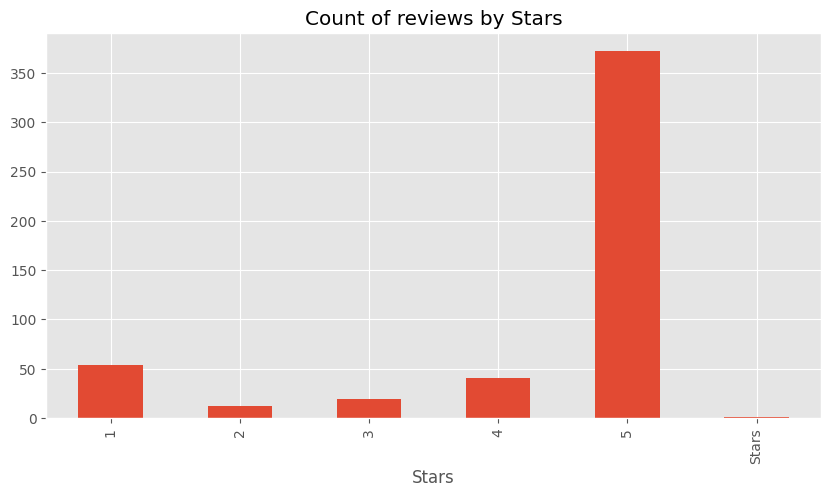

In [73]:
df['Stars'].value_counts().sort_index().plot(kind='bar', title='Count of reviews by Stars', figsize=(10, 5))

# Basic NLTK

In [74]:
example = df['Description'][440]
print(example)

performance is really top. however, the heat development (and power consumption) are also quite high


In [75]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [76]:
# Tokenize the review
tokens = nltk.word_tokenize(example)
tokens[:10]

['performance',
 'is',
 'really',
 'top',
 '.',
 'however',
 ',',
 'the',
 'heat',
 'development']

In [77]:
 nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [78]:
# Get part of speech tags
tagged = nltk.pos_tag(tokens)
tagged[:10]

[('performance', 'NN'),
 ('is', 'VBZ'),
 ('really', 'RB'),
 ('top', 'JJ'),
 ('.', '.'),
 ('however', 'RB'),
 (',', ','),
 ('the', 'DT'),
 ('heat', 'NN'),
 ('development', 'NN')]

In [79]:
nltk.download('maxent_ne_chunker')
nltk.download('words')

[nltk_data] Downloading package maxent_ne_chunker to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package maxent_ne_chunker is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


True

In [80]:
entities = nltk.chunk.ne_chunk(tagged)
entities.pprint()

(S
  performance/NN
  is/VBZ
  really/RB
  top/JJ
  ./.
  however/RB
  ,/,
  the/DT
  heat/NN
  development/NN
  (/(
  and/CC
  power/NN
  consumption/NN
  )/)
  are/VBP
  also/RB
  quite/RB
  high/JJ)


# VADER Sentiment Scoring - bag of words approach

In [81]:
from nltk.sentiment import SentimentIntensityAnalyzer
from tqdm.notebook import tqdm
nltk.download('vader_lexicon')

sia = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [82]:
# Testing model
sia.polarity_scores('I am very happy with the product!')

{'neg': 0.0, 'neu': 0.539, 'pos': 0.461, 'compound': 0.6468}

In [83]:
sia.polarity_scores('The product is very bad')

{'neg': 0.487, 'neu': 0.513, 'pos': 0.0, 'compound': -0.5849}

In [84]:
sia.polarity_scores(example)

{'neg': 0.0, 'neu': 0.87, 'pos': 0.13, 'compound': 0.2716}

In [85]:
nltk.download('vader_lexicon')
nltk.download('omw-1.4')
vader = SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [86]:
#lets's train our own model
def vader_polarity(text):
    """ Transform the output to a binary 0/1 result """
    score = vader.polarity_scores(text)
    total_positive_score = score['pos']
    total_negative_score = score['neg']
    total_neutral_score = score['neu']
    compound_score = score['compound']

    if (total_neutral_score > 1 and total_positive_score > total_negative_score and total_positive_score >= total_neutral_score):
        sentiment = 'Positive'
    elif (total_neutral_score > 1 and total_negative_score > total_positive_score and total_negative_score >= total_neutral_score):
        sentiment = 'Negative'
    elif (total_neutral_score > 1 and total_neutral_score > total_positive_score and total_neutral_score > total_negative_score):
        sentiment = 'Neutral'
    elif (total_neutral_score > 1 and total_negative_score == total_positive_score and total_negative_score >= total_neutral_score):
        sentiment = 'Neutral'
    elif (total_neutral_score <= 1 and total_positive_score == total_negative_score and total_positive_score == total_neutral_score):
        sentiment = "Neutral"
    elif (total_neutral_score <= 1 and total_positive_score > total_negative_score):
        sentiment = "Positive"
    elif (total_neutral_score <= 1 and total_negative_score > total_positive_score):
        sentiment = "Negative"
    else:
        if score['compound'] >= 0.5:
            sentiment = 'Positive'
        elif score['compound'] > -0.5 and score['compound'] < 0.5:
            sentiment = 'Neutral'
        elif score['compound'] <= -0.5:
            sentiment = 'Negative'
    return sentiment

In [87]:
#testing
vader_polarity("I am very happy with the product!")

'Positive'

In [88]:
vader_polarity("The product is very bad")

'Negative'

In [89]:
vader_polarity(example)

'Positive'

In [90]:
try:
    data = pd.read_csv(path+'/13GEN.csv', encoding='utf-8')
except UnicodeDecodeError:
    data = pd.read_csv(path+'/13GEN.csv', encoding='ISO-8859-1')

texts = data


In [91]:
for index, review in texts['Description'].astype(str).items():
    sentiment = vader_polarity(review)
    print(f"Review {index}: {sentiment}")

Review 0: Negative
Review 1: Positive
Review 2: Negative
Review 3: Positive
Review 4: Neutral
Review 5: Neutral
Review 6: Positive
Review 7: Negative
Review 8: Negative
Review 9: Positive
Review 10: Positive
Review 11: Positive
Review 12: Negative
Review 13: Positive
Review 14: Positive
Review 15: Positive
Review 16: Positive
Review 17: Positive
Review 18: Positive
Review 19: Positive
Review 20: Negative
Review 21: Positive
Review 22: Positive
Review 23: Neutral
Review 24: Positive
Review 25: Positive
Review 26: Negative
Review 27: Negative
Review 28: Positive
Review 29: Neutral
Review 30: Positive
Review 31: Neutral
Review 32: Positive
Review 33: Negative
Review 34: Positive
Review 35: Positive
Review 36: Positive
Review 37: Positive
Review 38: Positive
Review 39: Positive
Review 40: Positive
Review 41: Positive
Review 42: Neutral
Review 43: Positive
Review 44: Neutral
Review 45: Positive
Review 46: Positive
Review 47: Positive
Review 48: Negative
Review 49: Neutral
Review 50: Positiv

In [92]:
def vader_polarity(text):
    """ Determine sentiment using VADER """

    score = vader.polarity_scores(text)
    if score['compound'] >= 0.05:
        return 'Positive'
    elif score['compound'] <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

positive_count = 0
negative_count = 0
neutral_count = 0

for index, review in texts['Description'].astype(str).items():
    sentiment = vader_polarity(review)
    if sentiment == 'Positive':
        positive_count += 1
    elif sentiment == 'Negative':
        negative_count += 1
    elif sentiment == 'Neutral':
        neutral_count += 1

In [93]:
print(f"Positive Sentiments: {positive_count}")
print(f"Negative Sentiments: {negative_count}")
print(f"Neutral Sentiments: {neutral_count}")

Positive Sentiments: 561
Negative Sentiments: 116
Neutral Sentiments: 101



# Plotting VADER results

In [94]:
df['Description'] = df['Description'].astype(str).fillna('')

In [95]:
res = {}
for i, row in tqdm(df.iterrows(), total=len(df)):
    text = row['Description']
    myid = row['ID']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/500 [00:00<?, ?it/s]

In [96]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index': 'ID'})
vaders = vaders.merge(df, how='left')

In [97]:
vaders.head(50)

,ID,neg,neu,pos,compound,Name,Stars,Title,Date,Description,Desc_length
0,596.0,0.000,1.000,0.000,0.0000,sergio,1,Imballaggio i9 13900k,NaN,the media could not be loaded.,30
1,588.0,0.151,0.849,0.000,-0.2401,Amazon Customer,1,"It's junk, don't buy this. It won't boot up my...",NaN,not even worth throwing away money to buy. sta...,63
2,544.0,0.181,0.753,0.066,-0.6850,Wolfgang Werner,5,As described,NaN,i was close to give them a bad review but then...,244
3,645.0,0.000,0.812,0.188,0.4588,John M. Macros,4,Faster than expected,NaN,"havent used intel in a long time, glad i went ...",71
4,488.0,0.000,0.446,0.554,0.7351,Fortnite89,5,Una bella Bombetta,NaN,"excellent cpu performing, quick i recommend th...",58
5,212.0,0.000,0.323,0.677,0.6369,enzo,5,Venditore affidabilitÃ top,NaN,processore is best,18
6,389.0,0.000,0.594,0.406,0.6249,GOKUL,4,Product is great. Delivery was a let down,NaN,product is great. delivery was a let down.,42
7,528.0,0.000,0.793,0.207,0.8805,Bruce Kearns,5,It runs HOT!,NaN,what can you say about this processor that has...,226
8,245.0,0.557,0.114,0.330,-0.2500,Rudy,5,Performante,NaN,good cpu no problem,19
9,583.0,0.000,0.731,0.269,0.9537,Isaac Behage,5,Absolute unit for 1080p-1440p gaming,NaN,"really powerful cpu for sure, haven't even bee...",310


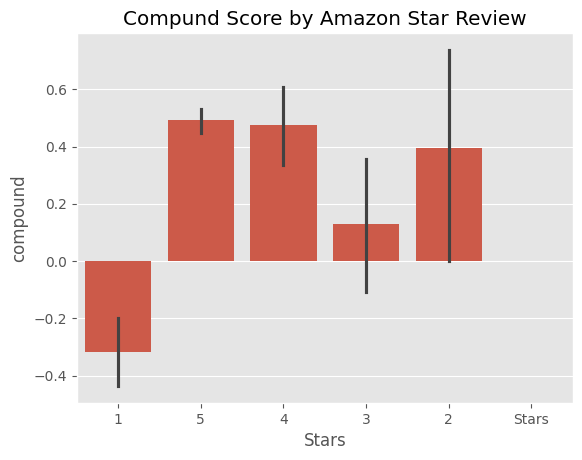

In [98]:
ax = sns.barplot(data=vaders, x='Stars', y='compound')
ax.set_title('Compund Score by Amazon Star Review')
plt.show()

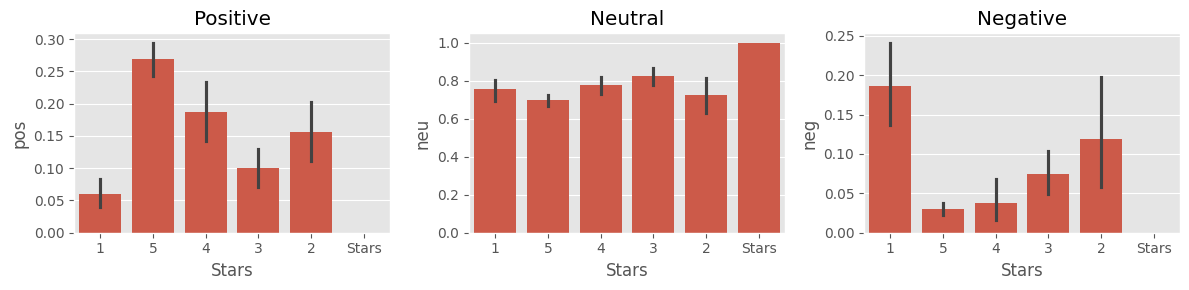

In [99]:
fig, axs = plt.subplots(1, 3, figsize=(12, 3))
sns.barplot(data=vaders, x='Stars', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='Stars', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='Stars', y='neg', ax=axs[2])
axs[0].set_title('Positive')
axs[1].set_title('Neutral')
axs[2].set_title('Negative')
plt.tight_layout()
plt.show()

In [100]:
df['Description'] = df['Description'].astype(str).fillna('')

In [101]:
df['vader_scores'] = df['Description'].apply(lambda text: sia.polarity_scores(text)['compound'])

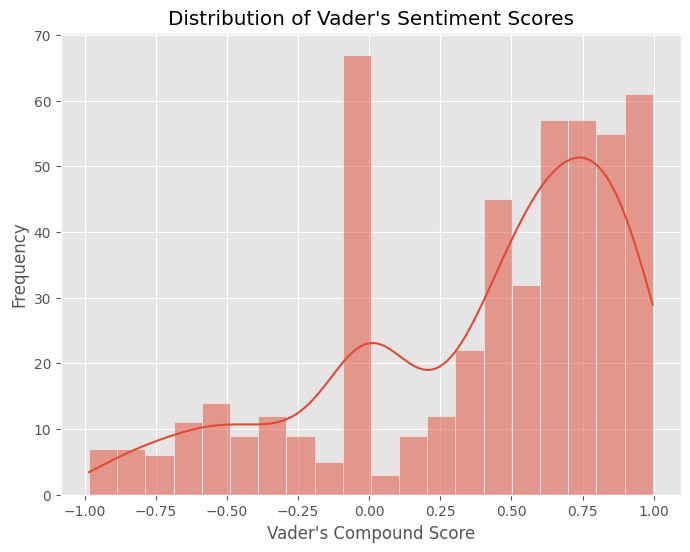

In [102]:
plt.figure(figsize=(8, 6))
sns.histplot(df['vader_scores'], bins=20, kde=True)
plt.title("Distribution of Vader's Sentiment Scores")
plt.xlabel("Vader's Compound Score")
plt.ylabel("Frequency")
plt.show()

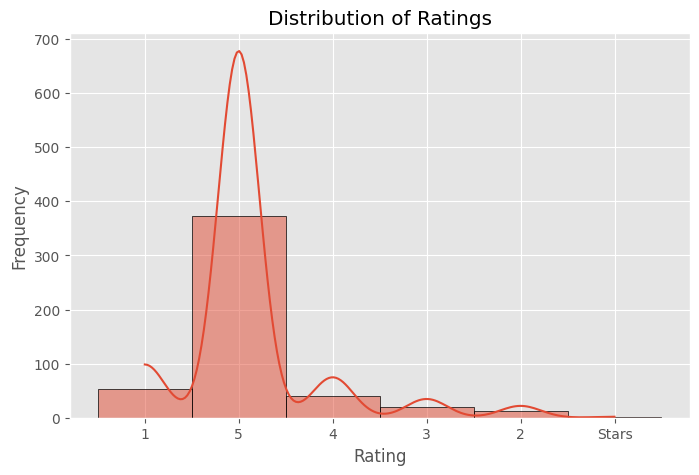

In [103]:
import matplotlib.pyplot as plt
import seaborn as sns



plt.figure(figsize=(8,5))
sns.histplot(df['Stars'], bins=10, kde=True,edgecolor='black')
plt.title('Distribution of Ratings')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.show()

In [104]:
df['Stars'] = pd.to_numeric(df['Stars'], errors='coerce')
df = df.dropna(subset=['Stars'])

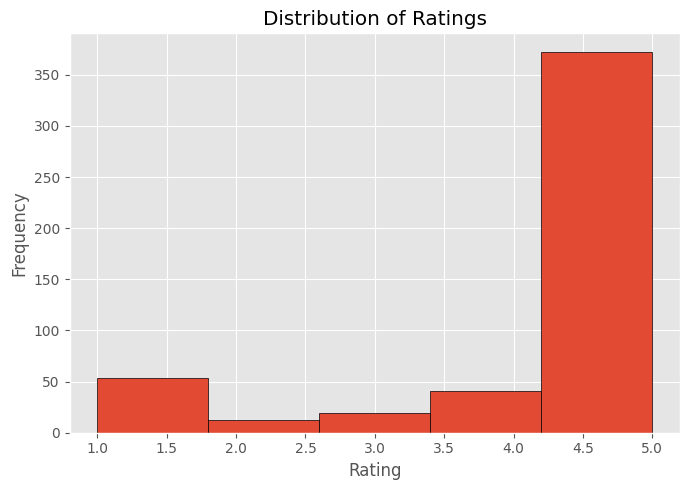

In [105]:
plt.figure(figsize=(7,5))
plt.hist(df['Stars'], bins=5,edgecolor='black')
plt.xlabel('Rating')
plt.ylabel('Frequency')
plt.title('Distribution of Ratings')
plt.tight_layout()
plt.show()